# Area Labeled Figure

In [98]:
from ipywidgets import interact, interactive
from IPython.display import display
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from nuclei_segmenter import loader as io, vis, quantify as quant

In [99]:
# Define useful cmap
HiLo_cmap = plt.cm.get_cmap('Greys_r').copy()
HiLo_cmap.set_under('b')
HiLo_cmap.set_over('r')

C:\Users\agucor\AppData\Local\Temp\ipykernel_17176\2592173235.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  HiLo_cmap = plt.cm.get_cmap('Greys_r').copy()


In [100]:
# DATA_DIR = pathlib.Path(r'C:\Users\afsiqb\Karolinska Institutet\Afshan Iqbal - EdU staining Non-IGF1 exp')
# IMPR_DIR = pathlib.Path(r'C:\Users\afsiqb\Karolinska Institutet\Afshan Iqbal - EdU staining Non-IGF1 exp\segmented')

DATA_DIR = pathlib.Path(r'C:\Users\afsiqb\OneDrive - Karolinska Institutet\Microwell plate experiments\EdU staining Non-IGF1 exp')
IMPR_DIR = pathlib.Path(r'C:\Users\afsiqb\OneDrive - Karolinska Institutet\Microwell plate experiments\EdU staining Non-IGF1 exp\segmented')

DATA_DIR = pathlib.Path(r'C:\Users\agucor\Karolinska Institutet\Afshan Iqbal - EdU staining Non-IGF1 exp')
IMPR_DIR = DATA_DIR / 'segmented'


file_list = [filepath for filepath in IMPR_DIR.rglob('*.tiff')]


file_dict = {this_file.stem: {'img_path': DATA_DIR / this_file.parent.stem /(this_file.stem + '.czi'), 'labeled_path': this_file} for this_file in file_list}

First choose the sample folder.

In [89]:
line_list = list(set([file.parent.stem for file in file_list]))

def choose_folder(folder):
    return folder

f = interactive(choose_folder, folder
                =line_list)
display(f)

interactive(children=(Dropdown(description='folder', options=('Wt1221', 'Ndr1224', 'Ndr1219', 'Ndr1220', 'WT12…

First you have to choose the file to open.

In [90]:
def choose_file(file):
    return file

def load_imgs(file):
    img = io.get_image(io.get_file(file_dict[file]['img_path']))
    labeled = io.get_labeled(file_dict[file]['labeled_path'])
    scale = io.get_pixel_size(io.get_file(file_dict[file]['img_path']))
    nuclei_props = pd.read_excel(file_dict[file]['labeled_path'].with_suffix('.xlsx'))
    return img, labeled, scale, nuclei_props

w = interactive(choose_file, file=[file_name for file_name, filepath in file_dict.items() if f.result in str(filepath['img_path'])])
display(w)

interactive(children=(Dropdown(description='file', options=('Ndr1220 hilar repeat EdU DAPI-11', 'Ndr1220 hilar…

Once you selected the file, run the following cell to see the images.

In [91]:
file = w.result
img, labels, scale, nuclei_props = load_imgs(file)
area_labeled = vis.relabel_by(labels, nuclei_props)

## Intensity Image

In [93]:
def make_int_figure(z, min_int=0, max_int=65535, scale_bar=100, size=1000, ini_x=0, ini_y=0):
    size_px = np.ceil(size / (scale['X'] * 10 ** 6)).astype(int)
    end_x = ini_x + size_px
    end_y = ini_y + size_px
    
    fig, axs = plt.subplots(1, 1)
    this_plot = plt.imshow(img[z][ini_y:end_y, ini_x:end_x], cmap=HiLo_cmap, rasterized=True, vmin=min_int, vmax=max_int)
    axs.axis('off')
    plt.colorbar(this_plot, ax=axs)
    
    scalebar = AnchoredSizeBar(axs.transData,
                           scale_bar/(scale['X'] * 10 ** 6), '', 'lower left', 
                           pad=1,
                           color='white',
                           frameon=False,
                           size_vertical=10)

    axs.add_artist(scalebar)
    return axs


int_f = interactive(make_int_figure, z=np.arange(0, len(area_labeled)), min_int=(0, 2000), max_int=(0, 65535), scale_bar=(5, 400), size=(200, 2000, 50), ini_x=(0, 1000), ini_y=(0, 1000))
display(int_f)

interactive(children=(Dropdown(description='z', options=(0, 1, 2, 3, 4), value=0), IntSlider(value=0, descript…

Once you are happy with how the figure looks, you can run the cell below to save the image as a vectors graphic (svg) that you can open with inkscape or illustrator.

In [94]:
axs = int_f.result
plt.sca(axs)
plt.savefig('./../results/figures/intensity_image_%s.svg' % w.result)

## Area Labelled Figure

In [92]:
def make_figure(z, min_area=1, max_area=400, scale_bar=100, size=1000, ini_x=0, ini_y=0):
    size_px = np.ceil(size / (scale['X'] * 10 ** 6)).astype(int)
    end_x = ini_x + size_px
    end_y = ini_y + size_px
    
    this_area_labeled = area_labeled[:, ini_y:end_y, ini_x:end_x]
    
    axs = vis.plot_area_labeled(this_area_labeled, z, area_labeled_limits=(min_area, max_area))
    scalebar = AnchoredSizeBar(axs.transData,
                           scale_bar/(scale['X'] * 10 ** 6), '', 'lower left', 
                           pad=1,
                           color='black',
                           frameon=False,
                           size_vertical=10)

    axs.add_artist(scalebar)
    return axs


f = interactive(make_figure, z=np.arange(0, len(area_labeled)), min_area=(0, 200), max_area=(0, 800), scale_bar=(5, 400), size=(200, 2000, 100), ini_x=(0, 1000), ini_y=(0, 1000))
display(f)

interactive(children=(Dropdown(description='z', options=(0, 1, 2, 3, 4), value=0), IntSlider(value=1, descript…

Once you are happy with how the figure looks, you can run the cell below to save the image as a vectors graphic (svg) that you can open with inkscape or illustrator.

In [95]:
axs = f.result
plt.sca(axs)
plt.savefig('./../results/figures/area_labeled_%s.svg' % w.result)

# Classified by size

This is not perfect, but if you need to separate them by size only, you can use the following cells.

If you only want big and small, you can put the small limit and big limit to the same value. You will have to manually remove and/or correct the colorbar on the border to reflect the sizes you are showing.

In [104]:
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list('size', ['#6495ED', '#FCE883', '#FF6347'], N=3)
cmap.set_under('white', alpha=0)

In [105]:
def make_figure_classified(z, small_limit=70, big_limit=300, scale_bar=50):
    this_img = area_labeled[z]
    class_img = np.zeros_like(this_img)
    class_img[np.logical_and(0 < this_img, this_img < small_limit)] = 1
    class_img[np.logical_and(this_img > small_limit, this_img < big_limit)] = 2
    class_img[this_img > big_limit] = 3
    
    fig, axs = plt.subplots(1, 1)
    this_im = axs.imshow(class_img, interpolation='none', vmin=0.9999, vmax=3, cmap=cmap)
    axs.contour(class_img > 0, colors='k', linewidths=0.1)
    plt.axis('off')
    
    scalebar = AnchoredSizeBar(axs.transData,
                           scale_bar/(scale['X'] * 10 ** 6), '', 'lower left', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=10)

    axs.add_artist(scalebar)
    plt.colorbar(this_im, ax=axs)
    return axs


f_1= interactive(make_figure_classified, z=np.arange(0, len(area_labeled)), small_limit=(0, 200), big_limit=(0, 800), scale_bar=(5, 400))
display(f_1)

interactive(children=(Dropdown(description='z', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=0), …

Once you are happy with how the figure looks, you can run the cell below to save the image as a vectors graphic (svg) that you can open with inkscape or illustrator.

In [106]:
axs = f_1.result
plt.sca(axs)
plt.savefig('size_classified.svg')

# Histograms

In [101]:
DATA_DIR = pathlib.Path(r'C:\Users\agucor\Karolinska Institutet\Afshan Iqbal - EdU staining Non-IGF1 exp')

# DATA_DIR = pathlib.Path(r'C:\Users\afsiqb\OneDrive - Karolinska Institutet\Microwell plate experiments\EdU staining Non-IGF1 exp')

In [102]:
nuclei_size = pd.read_excel(DATA_DIR / 'nuclei_size.xlsx', sheet_name=None)
dfs = []
for sample_name, sample_df in nuclei_size.items():
    sample_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
    sample_df['sample_name'] = sample_name
    dfs.append(sample_df)

nuclei_size = pd.concat(dfs, ignore_index=True)

In [103]:
def parse_condition(text):
    if 'wt' in text.lower():
        return 'WT'
    elif 'ndr' in text.lower():
        return 'Ndr'
    else:
        raise ValueError

def parse_cell_line(text):
    return text.split(' ')[0][-4:]

def parse_region(text):
    if 'peri' in text.lower():
        return 'Peripheral'
    elif 'hilar' in text.lower():
        return 'Hilar'
    else:
        raise ValueError

In [104]:
nuclei_size['condition'] = nuclei_size.sample_name.apply(parse_condition)
nuclei_size['cell_line'] = nuclei_size.sample_name.apply(parse_cell_line)
nuclei_size['region'] = nuclei_size.sample_name.apply(parse_region)

In [105]:
nuclei_size

,area_2D,eccentricity,equivalent_diameter_area,intensity_mean_2D,label,z,area_3D,intensity_mean_3D,area,volume,sample_name,condition,cell_line,region
0,1036,0.572159,36.319088,17185.166988,2,3,7322,10333.292133,79.040874,2234.506880,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar
1,765,0.443916,31.209426,14916.526797,4,5,3966,10774.640696,58.365124,1210.332462,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar
2,638,0.778079,28.501348,12053.150470,9,3,3742,7978.092197,48.675751,1141.972787,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar
3,711,0.623056,30.087760,17123.690577,10,3,5060,10684.135968,54.245233,1544.196232,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar
4,528,0.805742,25.928179,12609.446970,11,5,2418,9111.187758,40.283380,737.918279,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92810,121,0.916938,12.412171,26513.140496,3511,5,121,26513.140496,18.840016,113.040097,WT1225 Periph-9,WT,1225,Peripheral
92811,142,0.848895,13.446190,10091.507042,3512,5,142,10091.507042,22.109771,132.658626,WT1225 Periph-9,WT,1225,Peripheral
92812,268,0.844165,18.472363,10178.410448,3517,5,268,10178.410448,41.728300,250.369801,WT1225 Periph-9,WT,1225,Peripheral
92813,83,0.653466,10.280023,10708.361446,3520,5,83,10708.361446,12.923317,77.539901,WT1225 Periph-9,WT,1225,Peripheral


In [106]:
import seaborn as sns
condition_region_palette = {'WT Hilar': 'blue', 'Ndr Hilar': 'orange', 'WT Peripheral': '#89CFF0', 'Ndr Peripheral': '#FFD580'} #  {'Ndr': 'orange', 'WT': 'b'}
condition_palette = {'WT': (61/255, 133/255, 198/255), 'Ndr': (247/255, 137/255, 23/255)}

<AxesSubplot:xlabel='area', ylabel='Density'>

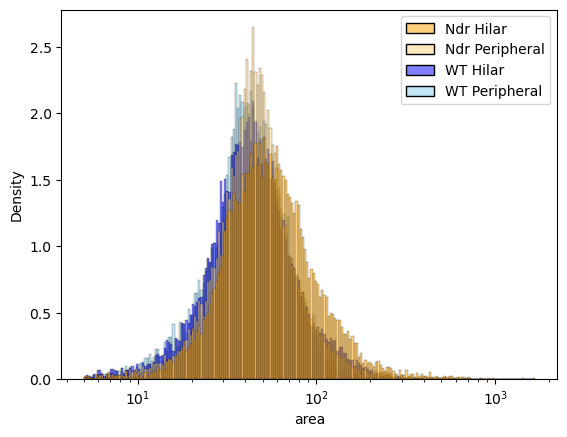

In [8]:
hue = nuclei_size[['condition', 'region']].apply(' '.join, axis=1).values
sns.histplot(data=nuclei_size, x='area', hue=hue, log_scale=True, stat="density", common_norm=False, palette=condition_region_palette)

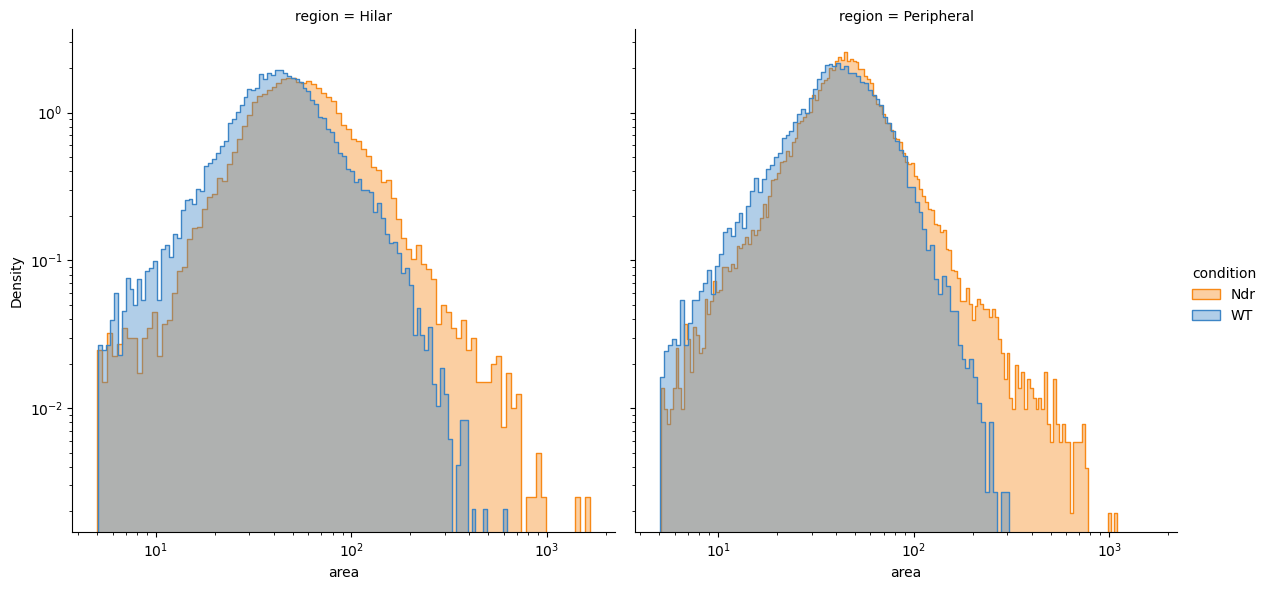

In [24]:
g = sns.FacetGrid(nuclei_size, col='region', hue='condition', palette=condition_palette, sharey=True, height=6, subplot_kws={'yscale': 'log'})
g.map_dataframe(sns.histplot, x='area', log_scale=True, stat="density", common_norm=False, element='step', alpha=0.4)
g.add_legend()
plt.savefig('../results/figures/nuclei_size_histogram_per_region.jpg')

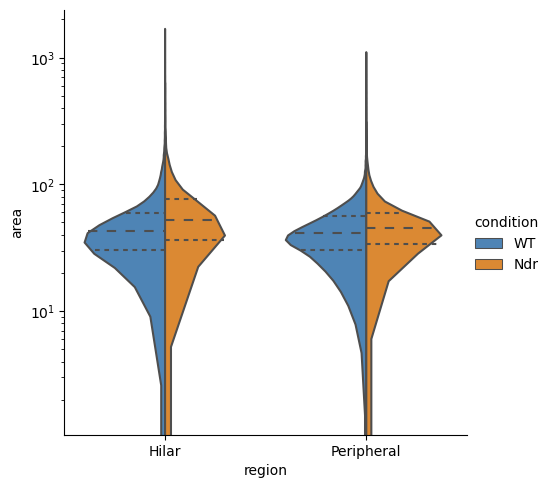

In [25]:
sns.catplot(data=nuclei_size, x='region', y='area', hue='condition', kind='violin', split=True, inner='quartiles', hue_order=['WT', 'Ndr'], palette=condition_palette)
plt.yscale('log')
plt.savefig('../results/figures/nuclei_size_violin_per_region.jpg')

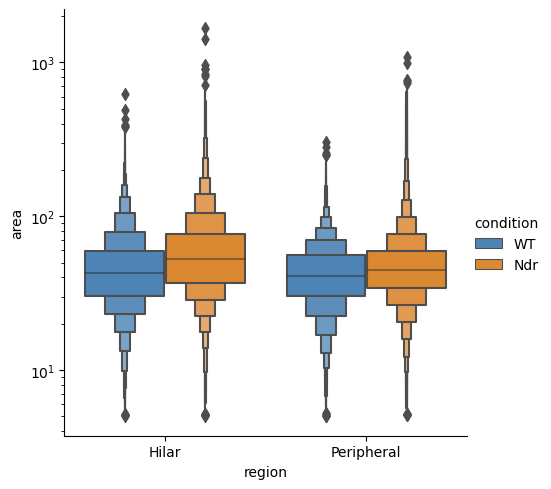

In [26]:
sns.catplot(data=nuclei_size, x='region', y='area', hue='condition', kind='boxen', palette=condition_palette, hue_order=['WT', 'Ndr'])
plt.yscale('log')
plt.savefig('../results/figures/nuclei_size_boxplot_per_region.jpg')

In [12]:
nuclei_size.query('condition == "WT"').sort_values('area').tail(10).sample_name.unique()

array(['WT1225 Hilar-13', 'WT1223 Hilar-7', 'WT1225 Hilar-5'],
      dtype=object)

In [114]:
nuclei_size['big'] = nuclei_size.area.values > 201

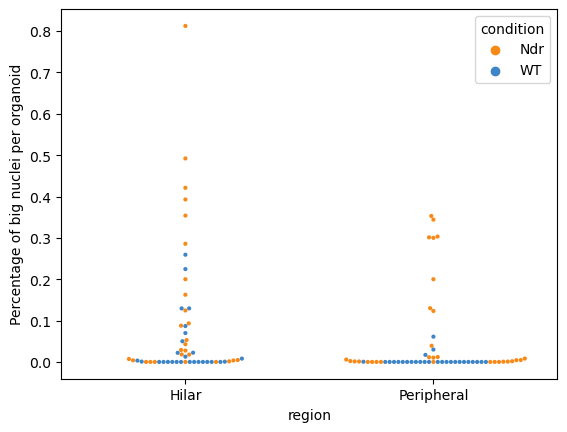

In [34]:
big_df = nuclei_size.groupby('sample_name').agg({'big': lambda x: sum(x)/len(x), 'condition': 'first', 'region': 'first', 'cell_line': 'first'})
sns.swarmplot(big_df, y='big', x='region', hue='condition', palette=condition_palette, size=3)
plt.ylabel('Percentage of big nuclei per organoid')
plt.savefig('../results/figures/percentage_big_nuclei_swarm_per_region.jpg')

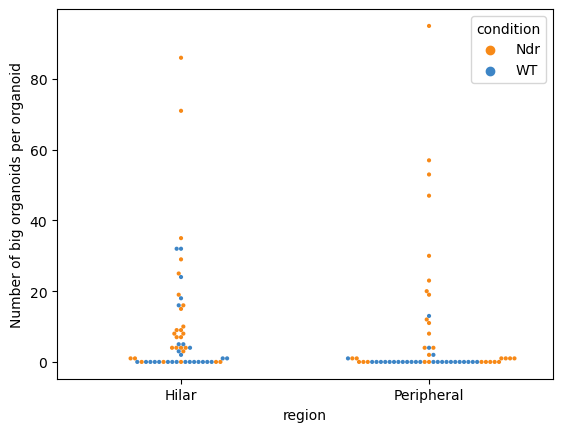

In [115]:
big_df = nuclei_size.groupby('sample_name').agg({'big': lambda x: sum(x), 'condition': 'first', 'region': 'first', 'cell_line': 'first'})
sns.swarmplot(big_df, y='big', x='region', hue='condition', palette=condition_palette, size=3)
plt.ylabel('Number of big organoids per organoid')
plt.savefig('../results/figures/number_big_nuclei_swarm_per_region.jpg')

In [27]:
nuclei_size

,area_2D,eccentricity,equivalent_diameter_area,intensity_mean_2D,label,z,area_3D,intensity_mean_3D,area,volume,sample_name,condition,cell_line,region,big
0,1036,0.572159,36.319088,17185.166988,2,3,7322,10333.292133,79.040874,2234.506880,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar,False
1,765,0.443916,31.209426,14916.526797,4,5,3966,10774.640696,58.365124,1210.332462,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar,False
2,638,0.778079,28.501348,12053.150470,9,3,3742,7978.092197,48.675751,1141.972787,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar,False
3,711,0.623056,30.087760,17123.690577,10,3,5060,10684.135968,54.245233,1544.196232,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar,False
4,528,0.805742,25.928179,12609.446970,11,5,2418,9111.187758,40.283380,737.918279,Ndr1219 p8 Hilar-1,Ndr,1219,Hilar,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94757,121,0.916938,12.412171,26513.140496,3511,5,121,26513.140496,18.840016,113.040097,WT1225 Periph-9,WT,1225,Peripheral,False
94758,142,0.848895,13.446190,10091.507042,3512,5,142,10091.507042,22.109771,132.658626,WT1225 Periph-9,WT,1225,Peripheral,False
94759,268,0.844165,18.472363,10178.410448,3517,5,268,10178.410448,41.728300,250.369801,WT1225 Periph-9,WT,1225,Peripheral,False
94760,83,0.653466,10.280023,10708.361446,3520,5,83,10708.361446,12.923317,77.539901,WT1225 Periph-9,WT,1225,Peripheral,False


## Cumulative distributions

The cumulative distributions of nuclei size genotype and region-wise are really good to distinguish and describe differences between these conditions. Let's make a figure showing the CDF and some confidence bounds to it.

In [107]:
def ecdf_value(a=None, N=None, ecdf_type=None, bound=None, **kwargs):
    assert a <= N

    # Note that the DKW inequality assumes the "classic"
    # definition of the empirical CDF, namely
    #
    #  ecdf(x) = (# samples <= x) / (# samples)
    #
    # However, we compute marginal CIs by minimizing
    # the size of the CI for the beta distribution; for
    # small confidence values, ecdf(x) may not
    # lie within the CI.  If, instead, we use the mode of the
    # beta distribution, we are guaranteed to fall within
    # the CI.
    #
    # So, we select the type of ecdf based on the estimator.
    if ecdf_type is None:
        if bound == "marginal_quick" or "marginal_opt":
            ecdf_type = "mode"
        elif bound == "DKW":
            ecdf_type = "classical"
        else:
            raise ValueError(f"Unknown bound {bound}")

    if ecdf_type == "classical":
        return a / N
    elif ecdf_type == "mean":
        return a / (N + 1)
    elif ecdf_type == "mode":
        return (a - 1) / (N - 1)
    else:
        ValueError(f"Unknown cdf_type {ecdf_type}")

        
def confidence_interval_bounds(**kwargs):
    bound = kwargs["bound"]
    confidence = kwargs["confidence"]

    if confidence == 0:
        v = ecdf_value(**kwargs)
        return (v, v)
    if confidence == 1:
        return (0, 1)

    if bound == "DKW":
        fn = cdf_CI_DKW
    elif bound == "marginal_quick":
        fn = cdf_CI_marginal_quick
    elif bound == "marginal_opt":
        fn = cdf_CI_marginal_opt
    else:
        raise ValueError(f"Unknown bound {bound}")

    lower, upper = fn(**kwargs)
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1

    return (lower, upper)


# Compute Dvoretzky-Kiefer-Wolfowitz confidence bands.
def cdf_CI_DKW(a=None, N=None, confidence=None, **kwargs):
    # See, e.g.,
    # https://en.wikipedia.org/wiki/Dvoretzky%E2%80%93Kiefer%E2%80%93Wolfowitz_inequality
    epsilon = np.sqrt(np.log(2.0 / (1 - confidence)) / (2.0 * float(N)))

    y = ecdf_value(a, N, ecdf_type="classical")
    return (y - epsilon, y + epsilon)

In [108]:
def get_cdf(data):
    max_points = 12000
    confidence = 0.95
    ecdf_type = None
    bound = 'DKW'

    N = len(data)
    data = np.sort(data)

    N_plot = min(N, max_points)
    # Choose N_plot numbers evenly spread between 0 and N-1 (inclusive)
    index_list = np.linspace(0, N - 1, N_plot).round().astype(int)

    # Compute estimates
    x = []
    y = []
    y_lower = []
    y_upper = []
    for i in index_list:
        a = i + 1
        x.append(data[i])  # i-th largest value
        y.append(ecdf_value(a=a, N=N, ecdf_type=ecdf_type, bound=bound))
        if N == 1:
            # Special case N==1 to avoid possible edge cases
            tail = (1.0 - confidence) / 2
            y_lower.append(tail)
            y_upper.append(1 - tail)
            break

        lower, upper = confidence_interval_bounds(
            a=a, N=N, confidence=confidence, bound=bound, ecdf_type=ecdf_type
        )
        y_lower.append(lower)
        y_upper.append(upper)
    x = np.array(x)
    y = np.array(y)
    y_upper = np.array(y_upper)
    y_lower = np.array(y_lower)

    DKW_epsilon_bound = None
    if bound == "DKW":
        DKW_epsilon_bound = 1 - y_lower[-1]

    results = dict(
        x=x,
        y=y,
        y_lower=y_lower,
        y_upper=y_upper,
        index_list=index_list,
        DKW_epsilon_bound=DKW_epsilon_bound,
    )
    return results

In [109]:
results = get_cdf(data = nuclei_size.query('condition == "Ndr" and region == "Peripheral"').area.values)

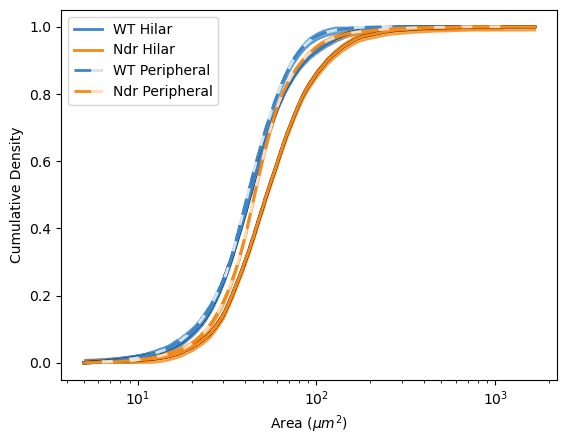

In [117]:
sns.set_style()

for cond_reg, color in condition_region_palette.items():
    cond, reg = cond_reg.split(' ')
    results = get_cdf(data = nuclei_size.query('condition == "%s" and region == "%s"' % (cond, reg)).area.values)
    # plt.semilogx(results['x'], results['y'], color='k', lw=2.5, alpha=0.8, ls='-' if reg == "Hilar" else '--')
    if reg == "Hilar":
        plt.semilogx(results['x'], results['y'], color='k', lw=2.5, alpha=0.8, ls='-')
        plt.semilogx(results['x'], results['y'], color=condition_palette[cond], lw=2, alpha=1, ls='-', label=cond_reg)
    else:
        # plt.semilogx(results['x'], results['y'], color='k', lw=2, alpha=0.8, ls='--')
        line, = plt.semilogx(results['x'], results['y'], color=condition_palette[cond], lw=2, alpha=1, ls='--', label=cond_reg, gapcolor='#ffdbb7' if cond == 'Ndr' else '#D1E5F4', dashes=[6, 4])
    plt.fill_between(results['x'], results['y_lower'], results['y_upper'], color=condition_palette[cond], alpha=0.7)

plt.legend()
plt.xlabel('Area ($\mu m^2$)')
plt.ylabel('Cumulative Density')

plt.savefig('../results/figures/cumulative_distributions.svg', format='svg')